In [1]:
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb
from scipy import stats
# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/home/mw/input/data2675/last2.csv')
# df = pd.read_csv('last2.csv')
df = df[["id","Accuracy","Source","timu","value"]]
df = df[df["id"].map(lambda x:361<=x<=560)]
df["id"] -= 360
df["index"] = range(len(df))
df = df.set_index("index")
df

,id,Accuracy,Source,timu,value
index,,,,,
0,1,Control,No Source,T,0
1,1,Control,No Source,T,1
2,1,Control,No Source,T,1
3,1,Control,No Source,T,0
4,1,Control,No Source,T,1
...,...,...,...,...,...
3195,200,Control,No Source,F,1
3196,200,Control,No Source,F,0
3197,200,Control,No Source,F,0


# 1 模型  
**在本部分，计划选用信号检测论的两个指标来观察是否有激励对被试的影响：辨别力指数d' 和 反应偏向c**  

![Image Name](https://pic2.zhimg.com/80/v2-494836d130488c33827259d6d0eb0401_1440w.webp)  

**来自知乎专栏：https://zhuanlan.zhihu.com/p/583336699**  
**辨别力指数d'：**  
$$  
d' = Φ^{{-1}}(击中率) - Φ^{{-1}}(虚报率)  
$$  

**其中$Φ^{{-1}}$函数将标准正态分布中的p转换成z分数，例如：$Φ^{{-1}}(0.05)$=-1.64 , 反应了被试辨别真假新闻的能力**  


**反应偏向c:**  
$$  
c = -\frac{Φ^{{-1}}(击中率) + Φ^{{-1}}(虚报率)}{2}  
$$  
**c定义为判断标准和分布中点（无反应偏向）的距离，c为负表示倾向于“是”反应，c为正表示倾向于“否”反应**

**根据想要测得的指标，进行建模：**  
$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.01in} & Y_i|\beta_0,\beta_1 & \stackrel{ind}{\sim} \text{Bern}(\pi_i) \;\; \text{ with } \;\; \pi_i =Φ(\beta_{0}+\beta_{1}X)\\  
\text{priors:} & & \beta_{0}  &  \sim N\left(0, 0.5^2 \right)  \\  
               & & \beta_1  & \sim N\left(0, 0.5^2 \right)\\  
\end{array}  
$$  

**其中 $Φ$函数将标准正态分布中的z分数转换成p概率**

**为了将模型的系数与这两个指标相对应，采用±0.5的编码方式**  

**建模中线性模型的部分为：**  
$$  
Z=\beta_{0}+\beta_{1}X  
$$  

**当被试看到真新闻时，被试做是反应的z分数为：**  
$$  
Z_{1}=\beta_{0}+\frac{1}{2}\beta_{1}  
$$  


**当被试看到假新闻时，被试做是反应的z分数为：**  
$$  
Z_{0}=\beta_{0}-\frac{1}{2}\beta_{1}  
$$  

**显然**  
$$  
\beta_{1} = Z_{1}(击中) - Z_{0}(虚报) = d'\\  
-\beta_{0} = -\frac{Z_{1} + Z_{0}}{2} = c  
$$  


**为了观察激励对被试判断的影响，根据有无激励将数据拆分成两部分，均建立相同的模型**

In [2]:
# 对变量进行编码
# Accurracy 题目是否有激励  -0.5无0.5有
df["Accuracy"] =  np.where(df['Accuracy'] == "Control", -0.5,0.5)
# timu 题目本身的真假 -0.5假0.5真
df["timu"] =  np.where(df['timu'] == "F", -0.5, 0.5)
df


,id,Accuracy,Source,timu,value
index,,,,,
0,1,-0.5,No Source,0.5,0
1,1,-0.5,No Source,0.5,1
2,1,-0.5,No Source,0.5,1
3,1,-0.5,No Source,0.5,0
4,1,-0.5,No Source,0.5,1
...,...,...,...,...,...
3195,200,-0.5,No Source,-0.5,1
3196,200,-0.5,No Source,-0.5,0
3197,200,-0.5,No Source,-0.5,0


In [3]:
# 单独分成两个表方便建模
df0 = df[df["Accuracy"] == -0.5]
df0.reset_index()
df1 = df[df["Accuracy"] == 0.5]
df1.reset_index()

,index,id,Accuracy,Source,timu,value
0,16,2,0.5,Source,0.5,1
1,17,2,0.5,Source,0.5,0
2,18,2,0.5,Source,0.5,1
3,19,2,0.5,Source,0.5,1
4,20,2,0.5,Source,0.5,0
...,...,...,...,...,...,...
1515,3179,199,0.5,No Source,-0.5,1
1516,3180,199,0.5,No Source,-0.5,0
1517,3181,199,0.5,No Source,-0.5,0
1518,3182,199,0.5,No Source,-0.5,0


In [4]:
with pm.Model(coords = {"id": df0.id.index})  as model0:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)          #定义beta_1

    timu = pm.MutableData("timu",df0.timu, dims="id")
    
    
    
    # 预测 lambda，自变量与先验结合
    mu = pm.Deterministic("mu", beta_0 + beta_1*timu,dims="id")
    
    pi = pm.Deterministic("pi",pm.invprobit(mu),dims="id") 

    likelihood = pm.Bernoulli("y_est", p = pi ,observed=df0.value, dims="id")
    
    trace0 = pm.sample(
    draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
    tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
    chains=4,                     # 链数
    discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
    random_seed=84735)
    
    ppc0 = pm.sample_posterior_predictive(trace0, random_seed=84735)
    
with pm.Model(coords = {"id": df1.id.index})  as model1:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)          #定义beta_1

    timu = pm.MutableData("timu",df1.timu, dims="id")
    
    
    
    # 预测 lambda，自变量与先验结合
    mu = pm.Deterministic("mu", beta_0 + beta_1*timu,dims="id")
    
    pi = pm.Deterministic("pi",pm.invprobit(mu),dims="id") 

    likelihood = pm.Bernoulli("y_est", p = pi ,observed=df1.value, dims="id")
    
    trace1 = pm.sample(
    draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
    tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
    chains=4,                     # 链数
    discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
    random_seed=84735)
    
    ppc1 = pm.sample_posterior_predictive(trace1, random_seed=84735)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 86 seconds.
Sampling: [y_est]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 90 seconds.
Sampling: [y_est]


### 1.2先验预测检验

In [5]:
model0_prior = pm.sample_prior_predictive(samples=50, 
                                          model=model0,
                                          random_seed=84735)


model1_prior = pm.sample_prior_predictive(samples=50, 
                                          model=model1,
                                          random_seed=84735)

Sampling: [beta_0, beta_1, y_est]
Sampling: [beta_0, beta_1, y_est]


In [6]:
model1_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

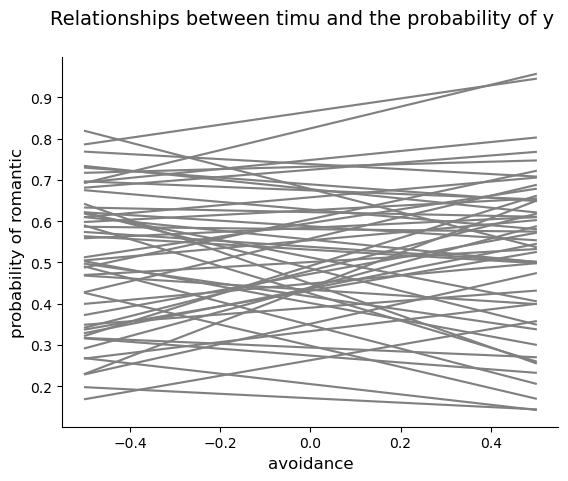

In [7]:
def prior_pic(log1_prior):
#对于一次抽样，可以绘制出一条曲线，结合循环绘制出50条曲线
    for i in range(log1_prior.prior.dims["draw"]):
        sns.lineplot(x = log1_prior.constant_data["timu"],
                    y = log1_prior.prior["pi"].stack(sample=("chain", "draw"))[:,i], c="grey" )
    #设置x、y轴标题和总标题    
    plt.xlabel("avoidance",
            fontsize=12)
    plt.ylabel("probability of romantic",
            fontsize=12)
    plt.suptitle("Relationships between timu and the probability of y",
            fontsize=14)
    sns.despine()
    plt.show()

prior_pic(model0_prior)

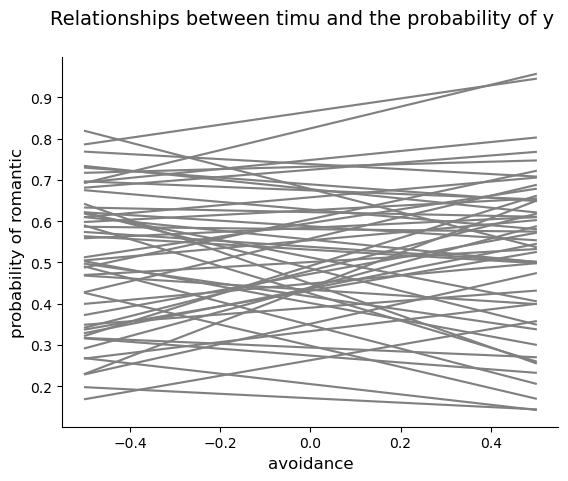

In [8]:
prior_pic(model1_prior)

### 1.3采样是否收敛

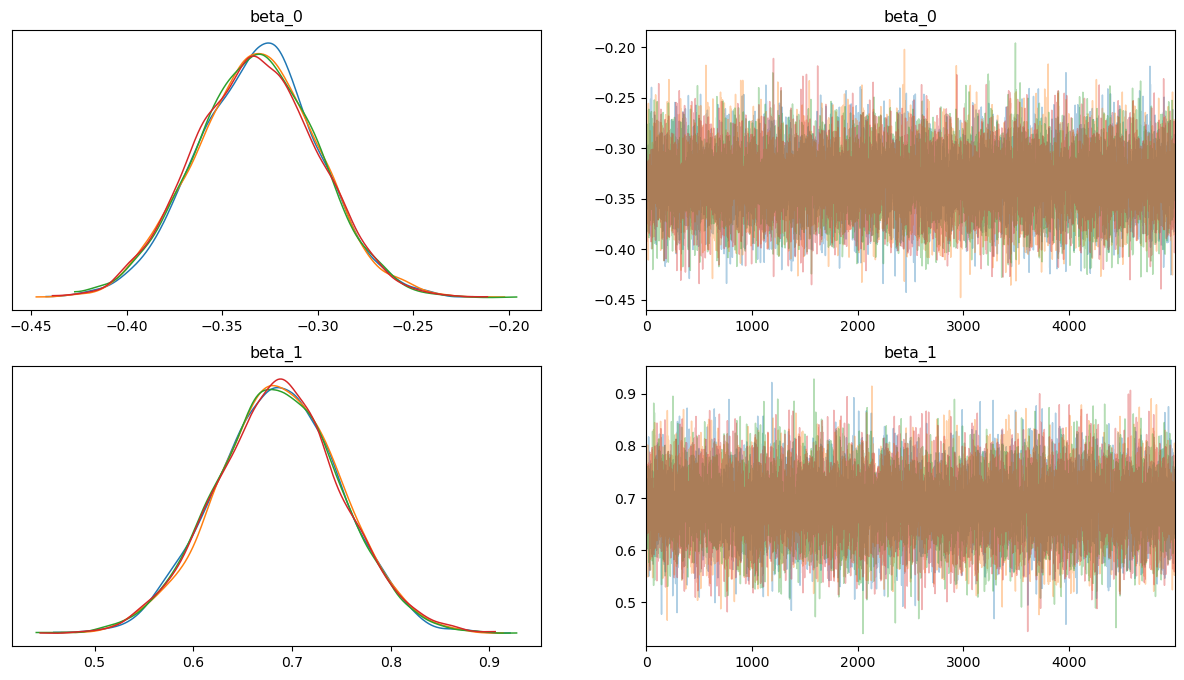

In [9]:
az.plot_trace(trace0,
              var_names=["beta_0","beta_1"],
              figsize=(15,8),
              compact=False)
plt.show()

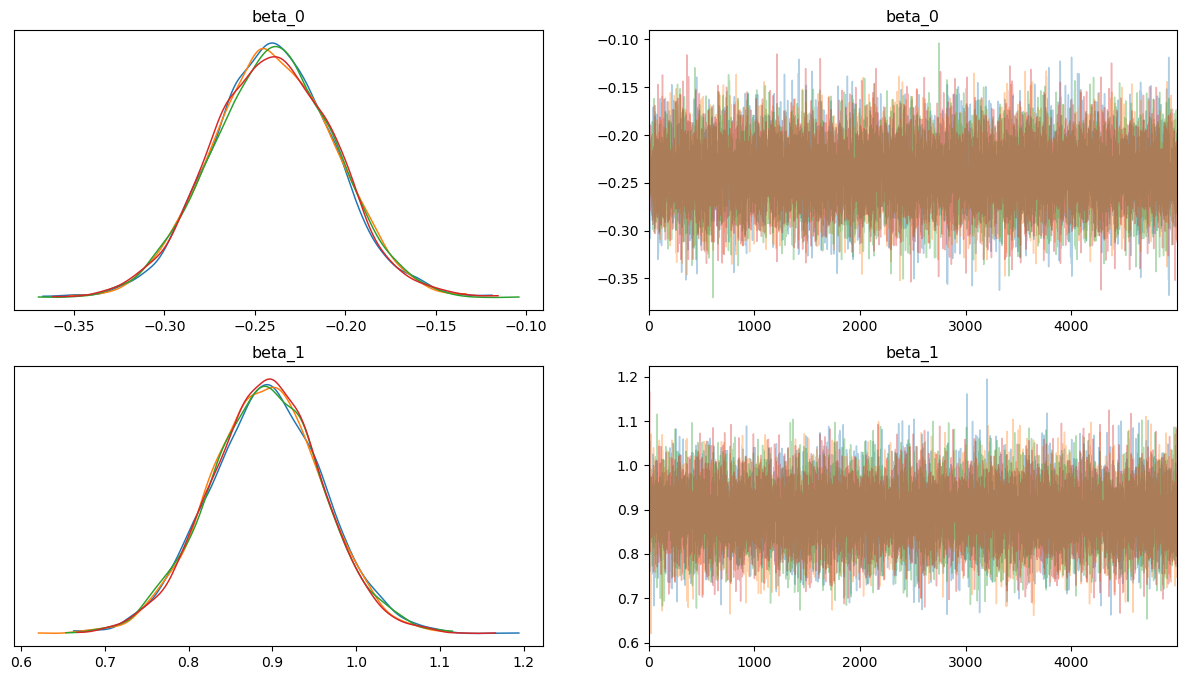

In [10]:
az.plot_trace(trace1,
              var_names=["beta_0","beta_1"],
              figsize=(15,8),
              compact=False)
plt.show()

### 1.4查看模型的系数

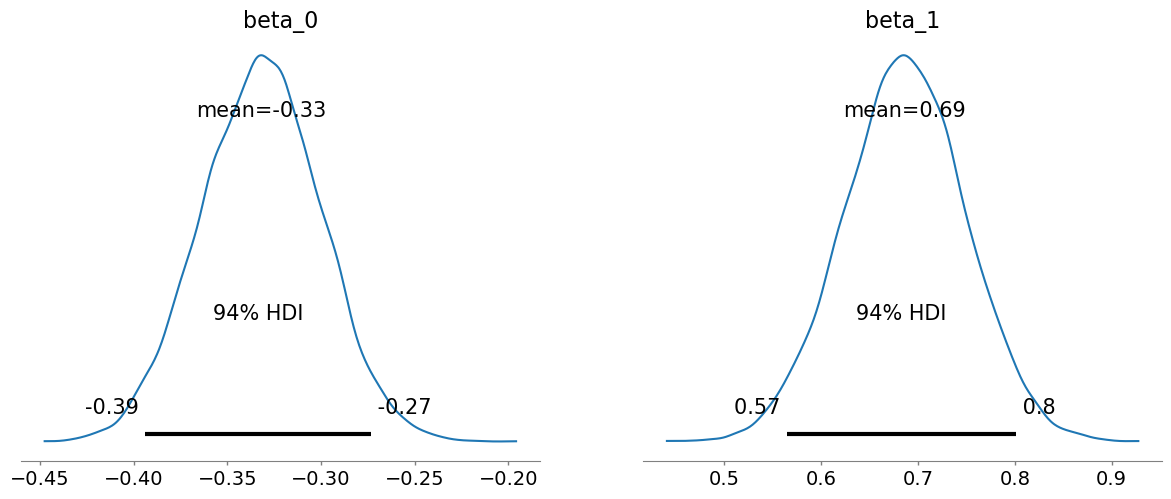

In [11]:
az.plot_posterior(trace0, var_names=["beta_0","beta_1"])
plt.show()

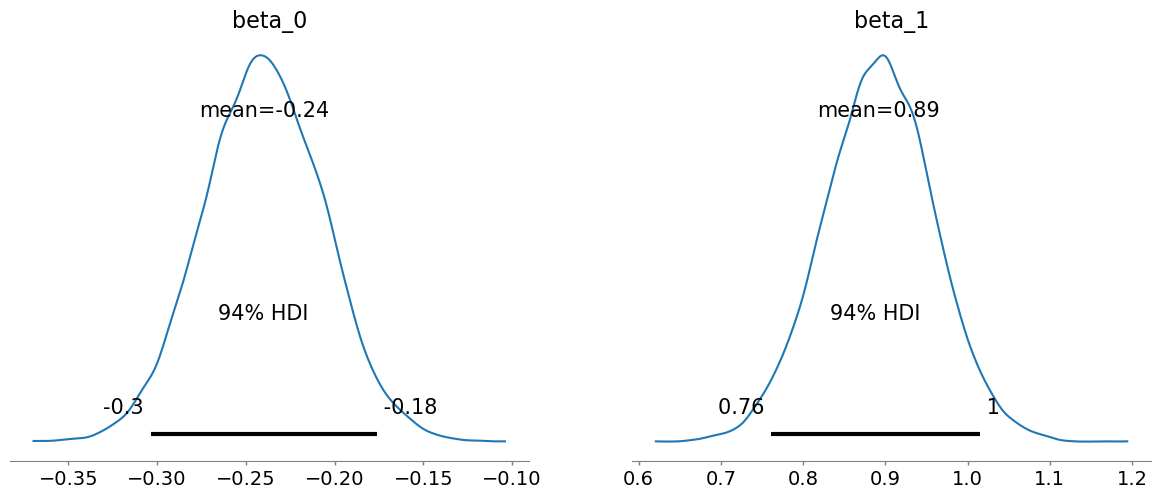

In [12]:
az.plot_posterior(trace1, var_names=["beta_0","beta_1"])
plt.show()

**可以看到，和没有激励相比，被试辨别力指数提高，做出“否”反应的倾向减弱了，这可能说明被试会更加仔细考虑新闻是否是真新闻**

### 1.4更进一步地，用传统的方法来计算信号检测论的结果，与贝叶斯的方法作为对比

In [13]:
def d(df):
    df1 = df[df["timu" ]== 0.5]
    df2 = df[df["timu" ]== -0.5]
    df1.groupby(["id"])["value"].sum()/8
    df2.groupby(["id"])["value"].sum()/8
    
    df_sig = pd.DataFrame({"sn":df1.groupby(["id"])["value"].sum()/8,"n":df2.groupby(["id"])["value"].sum()/8})

    df_sig['d'] = st.norm.ppf(df_sig["sn"].mean())-st.norm.ppf(df_sig["n"].mean()) 

    print(df_sig)

    return df_sig["d"].mean()

print(d(df[df["Accuracy"] == -0.5]),d(df[df["Accuracy"] == 0.5]))

        sn      n         d
id                         
1    0.750  0.500  0.696922
4    1.000  1.000  0.696922
5    0.250  0.250  0.696922
6    1.000  0.750  0.696922
8    0.000  0.000  0.696922
..     ...    ...       ...
188  0.500  0.125  0.696922
191  1.000  0.250  0.696922
192  0.500  0.250  0.696922
194  0.625  0.125  0.696922
200  0.250  0.375  0.696922

[105 rows x 3 columns]
        sn      n         d
id                         
2    0.750  0.250  0.908017
3    0.375  0.500  0.908017
7    0.500  0.125  0.908017
10   0.500  0.750  0.908017
13   1.000  0.750  0.908017
..     ...    ...       ...
195  0.875  0.500  0.908017
196  0.500  0.250  0.908017
197  0.500  0.250  0.908017
198  0.375  0.375  0.908017
199  0.500  0.125  0.908017

[95 rows x 3 columns]
0.6969223131753407 0.9080171837518388


**如果以均值作为预测结果，辨别力指数的d’值比较符合贝叶斯的预测结果**

### 1.5 对模型进一步改进，因为时间的原因，这一部分我们就不展示了，可以课后与老师讨论一下

In [14]:
with pm.Model() as modelx2:
    modelx2.add_coord('obs_id',df.index, mutable=True)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)          #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5) 
    beta_3 = pm.Normal("beta_3", mu=0, sigma=0.5)
    
    y = pm.MutableData('y', df.value, dims = 'obs_id')
    
    timu = pm.MutableData("timu",df.timu, dims="obs_id")
    acc = pm.MutableData("acc",df.Accuracy, dims="obs_id")

    # 预测 lambda，自变量与先验结合
    mu = pm.Deterministic("mu", beta_0 + beta_1*timu +beta_2*acc +beta_3*acc*timu,dims="obs_id")
    
    pi = pm.Deterministic("pi",pm.invprobit(mu),dims = "obs_id") 

    likelihood = pm.Bernoulli("y_est", p = pi ,observed=df.value, dims="obs_id")
    
    tracex2 = pm.sample(
    draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
    tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
    chains=4,                     # 链数
    discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
    random_seed=84735)
    
    
    
    ppcx2 = pm.sample_posterior_predictive(tracex2, random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 93 seconds.
Sampling: [y_est]


**结果符合预期**

In [15]:
df

,id,Accuracy,Source,timu,value
index,,,,,
0,1,-0.5,No Source,0.5,0
1,1,-0.5,No Source,0.5,1
2,1,-0.5,No Source,0.5,1
3,1,-0.5,No Source,0.5,0
4,1,-0.5,No Source,0.5,1
...,...,...,...,...,...
3195,200,-0.5,No Source,-0.5,1
3196,200,-0.5,No Source,-0.5,0
3197,200,-0.5,No Source,-0.5,0


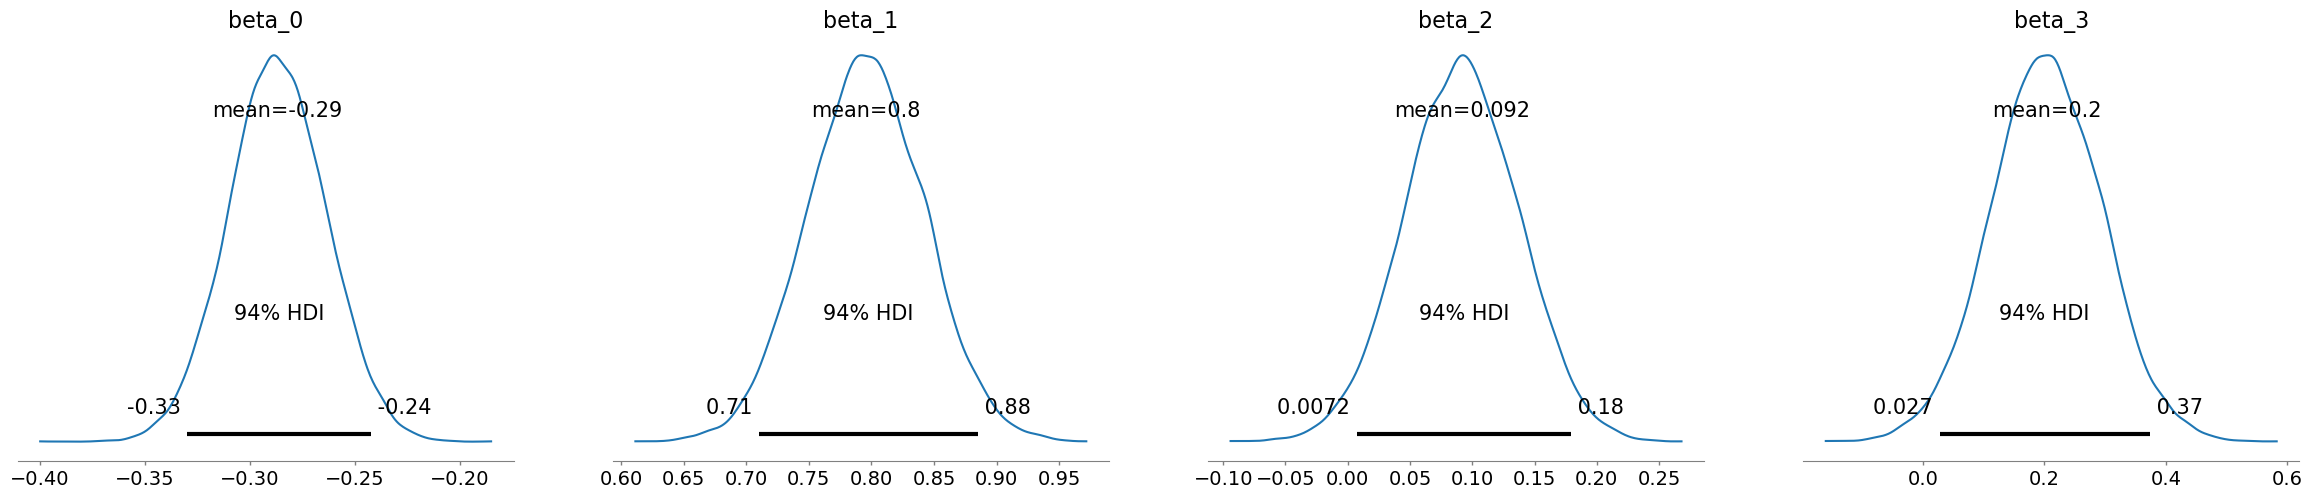

In [16]:
az.plot_posterior(tracex2,var_names=["beta_0","beta_1","beta_2","beta_3"])
plt.show()

**建模中线性模型的部分为：**  
$$  
Z=\beta_{0}+\beta_{1}X_{1}  +\beta_{2}X_{2}  +\beta_{3}X_{1}X_{2}  
$$  

**有激励时 当被试看到真新闻时，被试做是反应的z分数为：**  
$$  
Z_{1}=\beta_{0}+\frac{1}{2}\beta_{1} +\frac{1}{2}\beta_{2}+\frac{1}{4}\beta_{3}    
$$  


**有激励时 当被试看到假新闻时，被试做是反应的z分数为：**  
$$  
Z_{2}=\beta_{0}-\frac{1}{2}\beta_{1} +\frac{1}{2}\beta_{2}-\frac{1}{4}\beta_{3}    
$$  
**无激励时 当被试看到真新闻时，被试做是反应的z分数为：**  
$$  
Z_{3}=\beta_{0}+\frac{1}{2}\beta_{1} -\frac{1}{2}\beta_{2}-\frac{1}{4}\beta_{3}     
$$  

**无激励时 当被试看到假新闻时，被试做是反应的z分数为：**  
$$  
Z_{4}=\beta_{0}-\frac{1}{2}\beta_{1} -\frac{1}{2}\beta_{2}+\frac{1}{4}\beta_{3}    
$$  
**显然 **  
$$  
\beta_{3} = [Z_{1}(击中 有激励) - Z_{2}(虚报 有激励)] - [Z_{3}(击中 无激励) - Z_{4}(虚报 无激励)]= d'(有激励) - d'(无激励) \\  
$$  

$$  
-\beta_{0} = \frac{[-\frac{Z_{1} + Z_{2}}{2}+-\frac{Z_{3}+Z_{4}}{2}]}{2} = \frac{c(有激励)+c(无激励)}{2}  
$$  

$$  
\beta_{1} = [\frac{Z_{1} - Z_{2}+Z_{3}-Z_{4}}{2}] = \frac{d(有激励)+d(无激励)}{2}  
$$  

$$  
-\beta_{2} = -\frac{Z_{1} + Z_{2}}{2}--\frac{Z_{3}+Z_{4}}{2} =  c(有激励)-c(无激励)  
$$  

### 2 加入用于预测的题目

In [17]:
dfp = pd.read_csv('/home/mw/input/datapre2117/last3.csv')
# dfp = pd.read_csv('last3.csv')
dfp = dfp[["id","Accuracy","Source","timu","value"]]
dfp = dfp[dfp["id"].map(lambda x:361<=x<=560)]
dfp["id"] -= 360
dfp["index"] = range(len(dfp))
dfp = dfp.set_index("index")
dfp["Accuracy"] =  np.where(dfp['Accuracy'] == "Control", -0.5,0.5)
# timu 题目本身的真假 -0.5假0.5真
dfp["timu"] =  np.where(dfp['timu'] == "F", -0.5, 0.5)
dfp

,id,Accuracy,Source,timu,value
index,,,,,
0,1,-0.5,No Source,0.5,0
1,1,-0.5,No Source,0.5,0
2,1,-0.5,No Source,0.5,1
3,1,-0.5,No Source,0.5,1
4,1,-0.5,No Source,-0.5,0
...,...,...,...,...,...
1595,200,-0.5,No Source,0.5,1
1596,200,-0.5,No Source,-0.5,0
1597,200,-0.5,No Source,-0.5,0


In [18]:
pred_coords ={"obs_id":dfp.index} 

with modelx2:
    # 传入数据
    pm.set_data({"timu": dfp.timu.values,
                 "acc": dfp.Accuracy.values,
                 "y": dfp.value.values},
                coords=pred_coords
                )   
    # 生成对因变量的预测
    prediction = pm.sample_posterior_predictive(tracex2, 
                                                var_names=["y_est"],
                                                predictions=True,
                                                random_seed=84735,
                                                extend_inferencedata=True)
    
prediction

Sampling: [y_est]


Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [19]:
#stack(sample = ("chain", "draw")：将每一个X对应的4*5000个后验预测值合并到一个维度sample
#对于每一个X，需要计算其20000个值的平均值，因此将dim设置为sample
pred_pi = prediction.predictions.y_est.stack(sample = ("chain", "draw")).mean(dim="sample")
# 转换为数据框
pred_pi = pred_pi.to_dataframe()

#将原数据中的X 和Y存入数据框
pred_pi["timu"] = prediction.predictions_constant_data.timu.values
pred_pi["acc"] = prediction.predictions_constant_data.acc.values
pred_pi["y"] = prediction.predictions_constant_data.y.values
#根据分类标准（50-50）生成最终的分类结果
pred_pi["y_pred"] = np.where(pred_pi["y_est"] >= 0.5, 1, 0)
pred_pi

,y_est,timu,acc,y,y_pred
obs_id,,,,,
0,0.50525,0.5,-0.5,0,1
1,0.50745,0.5,-0.5,0,1
2,0.50065,0.5,-0.5,1,1
3,0.50705,0.5,-0.5,1,1
4,0.25165,-0.5,-0.5,0,0
...,...,...,...,...,...
1595,0.50425,0.5,-0.5,1,1
1596,0.25530,-0.5,-0.5,0,0
1597,0.24560,-0.5,-0.5,0,0


### 2.1 模型预测的结果

In [20]:
confusion_matrix = pd.crosstab(pred_pi["y"], pred_pi["y_pred"], 
                              rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,532,259
1,290,519


In [21]:
true_positive = confusion_matrix.at[1, 1]
false_positive = confusion_matrix.at[0, 1]
true_negative = confusion_matrix.at[0, 0]
false_negative = confusion_matrix.at[1, 0]
# 代入公式
accuracy = (true_positive + false_negative) /(true_positive + false_positive + true_negative + false_negative)
sensitivity = (true_positive) /(true_positive + false_negative)
specificity = (true_negative) / (true_negative + false_positive)

print("准确性:", accuracy)
print("敏感性:", sensitivity)
print("特异性:", specificity)

准确性: 0.505625
敏感性: 0.6415327564894932
特异性: 0.672566371681416
